# COVID-19 HERD CALCULATOR

###  Set-Up for Forecasting

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..') # only run once - I need to improve how we handle these relative paths, but this will work for now

In [4]:
import pandas as pd
import numpy as np
import sklearn.metrics as metrics

import sys
sys.path.insert(1,'../yyg-seir-simulator')

import run_simulation

In [5]:
cd yyg-seir-simulator

/Users/mauriceburger/yyg-seir-simulator


### Run Youyang Gu's SEIR infection simulation for Philadelphia

In [6]:
!python run_simulation.py -v --best_params_dir best_params/latest --country US --region PA --subregion "Philadelphia" --simulation_end_date 2020-10-31  --save_csv_fname philadelphia_simulation.csv

YYG/C19PRO Simulator
Current time: 2021-01-19 12:25:18.208039
Loading params file: best_params/latest/subregion/US_PA_Philadelphia.json
best params type: mean
US | PA | Philadelphia
Parameters:
INITIAL_R_0               : 3.786765484922743
LOCKDOWN_R_0              : 0.862126469543858
INFLECTION_DAY            : 2020-03-16
RATE_OF_INFLECTION        : 0.38090896211990627
LOCKDOWN_FATIGUE          : 1.0
DAILY_IMPORTS             : 341.0675605457681
MORTALITY_RATE            : 0.010000000000000002
REOPEN_DATE               : 2020-06-15
REOPEN_SHIFT_DAYS         : -0.17785118910400016
REOPEN_R                  : 1.1030124623303692
REOPEN_INFLECTION         : 0.2987461710903824
POST_REOPEN_EQUILIBRIUM_R : 0.9755569564839857
FALL_R_MULTIPLIER         : 1.0021399641171804
--------------------------
Running simulation...
--------------------------
1   - 2020-03-01 - New / total infections: 341 / 341 - Hospital beds in use: 0 - New / total deaths: 0.00 / 0.0 - Mean R: 3.787 - IFR: 1.00%
2   - 2

### Create a DataFrame using the generated csv file

In [7]:
df = pd.read_csv('philadelphia_simulation.csv')
df.iloc[[*range(5), *range(-5, 0)]]

,# dates,infections,hospitalizations,deaths,mean_r_t
0,2020-03-01,341.067561,0.0,0.000000,3.786765
1,2020-03-02,341.067561,0.0,0.000000,3.772705
2,2020-03-03,341.067561,0.0,0.000000,3.766232
3,2020-03-04,341.067561,0.0,0.000000,3.756810
4,2020-03-05,341.067561,0.0,0.000000,3.743129
240,2020-10-27,1031.936540,159.0,2.023139,1.105808
241,2020-10-28,1056.373420,162.0,2.050559,1.108195
242,2020-10-29,1081.804261,165.0,2.079300,1.110575
243,2020-10-30,1108.270856,168.0,2.109401,1.112948
244,2020-10-31,1135.817066,171.0,2.140906,1.115315


In [8]:
df.describe()

,infections,hospitalizations,deaths,mean_r_t
count,245.000000,245.000000,245.000000,245.000000
mean,1293.473522,268.889796,7.398696,1.117750
std,1181.479869,263.673062,8.686049,0.632598
min,341.067561,0.000000,0.000000,0.823261
25%,550.514291,120.000000,1.677064,0.837014
50%,654.676814,133.000000,2.079300,0.973351
75%,1641.106952,362.000000,11.794712,1.046020
max,4649.927179,985.000000,27.738627,3.786765


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245 entries, 0 to 244
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   # dates           245 non-null    object 
 1   infections        245 non-null    float64
 2   hospitalizations  245 non-null    float64
 3   deaths            245 non-null    float64
 4   mean_r_t          245 non-null    float64
dtypes: float64(4), object(1)
memory usage: 9.7+ KB


### Prepare DataFrame for forecasting

In [10]:
df = df.drop(columns=['hospitalizations', 'deaths' , 'mean_r_t'])

### Set up Facebook Prophet forecasting model

In [11]:
!pip install fbprophet

In [12]:
from fbprophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [13]:
df.columns = ['ds', 'y']
m = Prophet(yearly_seasonality=False)
m.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
future = m.make_future_dataframe(periods=365)
future.tail()

,ds
605,2021-10-27
606,2021-10-28
607,2021-10-29
608,2021-10-30
609,2021-10-31


### Forecast infection rates using Facebook prophet model

In [15]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
605,2021-10-27,387.902382,-2970.122987,3632.482559
606,2021-10-28,392.888061,-2782.104507,3575.598510
607,2021-10-29,401.552955,-2852.186615,3590.590289
608,2021-10-30,414.774987,-2821.740430,3705.970350
609,2021-10-31,344.108815,-2825.290183,3598.849917


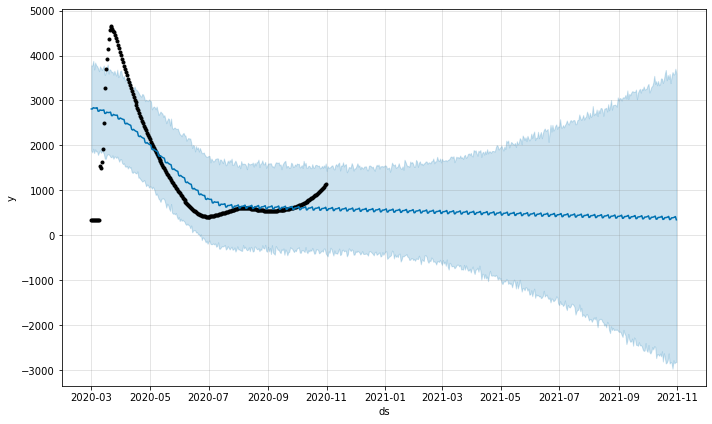

In [16]:
fig1 = m.plot(forecast)

### Integrate dataset with newest case numbers from Philadelphia

In [18]:
df_new_data = pd.read_csv('covid_cases_by_date.csv')
df_new_data = df_new_data[df_new_data.test_result != 'negative']
df_new_data = df_new_data.drop(columns = ['the_geom','the_geom_webmercator', 'test_result'])
df_new_data['collection_date'] = pd.to_datetime(df_new_data.collection_date)
df['ds'] = pd.to_datetime(df.ds)
df_new_data = df_new_data.sort_values(by='collection_date')
df_new_data
#df_new_data.columns = ['ds', 'positive_tests']

,collection_date,count,# dates,infections,hospitalizations,deaths,mean_r_t,Unnamed: 10,collection_date.1,Unnamed: 12,Unnamed: 13
46,2020-01-04,446,16.04.20,2957.794107,930.0,20.648073,0.839557,#REF!,27.04.20,NaN,NaN
106,2020-01-05,332,15.06.20,567.614572,233.0,10.136794,0.824673,#REF!,26.06.20,NaN,NaN
167,2020-01-06,108,15.08.20,588.581362,125.0,1.542611,0.955184,#REF!,26.08.20,NaN,NaN
227,2020-01-07,176,14.10.20,788.918460,134.0,1.771952,1.074252,#REF!,25.10.20,NaN,NaN
290,2020-01-08,64,NaN,NaN,NaN,NaN,NaN,NaN,27.12.20,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
610,2021-08-01,667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
612,2021-09-01,378,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
613,2021-10-01,259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615,2021-11-01,654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df = pd.read_csv('philadelphia_simulation.csv')
df = df.drop(columns=['hospitalizations', 'deaths', 'mean_r_t'])
df.columns = ['ds', 'infections']
df['ds'] = pd.to_datetime(df.ds)
df = pd.merge(df, df_new_data)
df

### Run linear regression model on positive tests to predict infections for full set of dates

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib notebook

In [ ]:
# test train split for supervised training
X_train, X_test, y_train, y_test = train_test_split(df.positive_tests, df.infections)

In [ ]:
# test train split visualization
plt.scatter(X_train, y_train, label = 'Training data', color = 'r', alpha =.7)
plt.scatter(X_test, y_test, label = 'Testing data', color = 'g', alpha =.7)
plt.legend()
plt.title('Test Train Split')
plt.show()

In [ ]:
# create linear model
LR = LinearRegression()
LR.fit(X_train.values.reshape(-1,1), y_train.values)


In [ ]:
# use model to predict on Test data
prediction = LR.predict(X_test.values.reshape(-1,1))

# plot prediction line against actual test data
plt.plot(X_test, prediction, label='Linear Regression', color = 'b')
plt.legend()
plt.show()

In [ ]:
# score this model
LR.score(X_test.values.reshape(-1,1), y_test.values)

In [ ]:
prediction

In [ ]:
# use this model to predict for all dates
full_prediction = LR.predict(df_new_data.positive_tests.values.reshape(-1,1))
df_new_data = df_new_data.append(dict(zip(df_new_data.columns, full_prediction)), ignore_index=True)
df_new_data

In [ ]:
# append all predictions to the original dataset


# Vaccination Predictions

In [ ]:
df_vaccines = pd.read_csv('Prof.csv')
df_vaccines.columns = ['ds', 'y']
df_vaccines

In [ ]:
n = Prophet()
n.fit(df_vaccines)

In [ ]:
vaccine_future = n.make_future_dataframe(periods=365)
vaccine_future.tail()

In [ ]:
vaccine_forecast = n.predict(vaccine_future)
vaccine_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

In [ ]:
# print infection and vaccination projection graphs
fig1 = m.plot(forecast)
fig2 = n.plot(vaccine_forecast)